In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymongo
import pyarrow as pa
import pyarrow.parquet as pq
from pymongoarrow.monkey import patch_all
patch_all()

from config import Config

client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]

In [3]:
# aggregate + save
from loader import run
need_to_rebuild_parquets = False # set to True to rebuild parquet files from DB
if need_to_rebuild_parquets:
    run()

In [4]:
# load
phishing = pq.read_table('floor/phishing.parquet')
benign_u = pq.read_table('floor/benign.parquet')

from transformers.drop_nontrain import drop_nontrain
phishing = drop_nontrain(phishing)
benign_u = drop_nontrain(benign_u)

# realign schemas (parquet files save in nonsense orders)
phishing_order = phishing.schema.names
benign = benign_u.select(phishing_order)

data = pa.concat_tables([phishing, benign])
df = data.to_pandas()
from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)
df

import pandas as pd


pd.set_option('display.max_rows', 2000)

df


,label,tls_CA_certs_in_chain_ratio,tls_broken_chain,tls_chain_len,tls_cipher_id,tls_client_auth_crt_count,tls_common_name_count,tls_critical_extensions,tls_expired_chain,tls_has_tls,...,dns_soa_refresh,dns_soa_retry,dns_soa_expire,dns_soa_neg_resp_caching_ttl,dns_mx_mean_len,dns_mx_mean_entropy,dns_domain_name_in_mx,dns_txt_google_verified,dns_txt_spf_exists,dns_txt_mean_entropy
0,misp:phishing,0.500000,0.0,4.0,0.0,2.0,3.0,7.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,21.0,0.180235,0,0,0,NaN
4,misp:phishing,0.333333,0.0,3.0,1.0,2.0,3.0,5.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295348,benign:unknown,0.500000,0.0,4.0,2.0,2.0,4.0,7.0,0.0,True,...,10000.0,2400.0,604800.0,3600.0,NaN,NaN,0,0,0,NaN
295349,benign:unknown,0.333333,0.0,3.0,2.0,2.0,3.0,5.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
295350,benign:unknown,0.333333,0.0,3.0,2.0,2.0,3.0,5.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
295351,benign:unknown,0.333333,0.0,3.0,0.0,2.0,3.0,5.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime

#le = LabelEncoder()
#labels = le.fit_transform(df['label'])

class_map = {"benign:unknown": 0, "misp:phishing": 1}
labels = df['label'].apply(lambda x: class_map[x])

features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

start = datetime.datetime.now()

params = {
    "max_depth": 9,
    "eta": 0.21,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    "sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.19,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "depthwise",
    "max_bin": 2048,
}
trees = 300

model = XGBClassifier(
  **params, n_estimators=trees
)
do_cross_val = True
if do_cross_val:
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

finish = datetime.datetime.now()
delta = finish - start
print(delta)

F1: 94.21% (0.19%)
0:00:25.023750


In [60]:
## Hyperparameter tuning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datetime

class_map = {"benign:unknown": 0, "misp:phishing": 1}


labels = df['label'].apply(lambda x: class_map[x])
features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

params = {
    "eta": 0.21,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    
    "max_depth": 9,
    "min_child_weight": 2,
    "sampling_method": "gradient_based",
    "subsample": 0.6,
    "gamma": 0.19,
    "grow_policy": "depthwise",
    "max_bin": 2048,
    "lambda": 1.0,
    "alpha": 0.0,
    "n_estimators": 300
}

clf = XGBClassifier(**params)

grid = {
    "lambda": [1.0, 1.05, 1.1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

grid_search = GridSearchCV(estimator=clf,
                           param_grid=grid,
                           #n_jobs=-1,
                           cv=cv,
                           #scoring='neg_log_loss',#'f1',
                           scoring='f1',
                           verbose=3,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_

scores = pd.DataFrame(grid_search.cv_results_)
col_names = ['mean_train_score', 'mean_test_score']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ....lambda=1.0;, score=(train=0.982, test=0.939) total time=   4.8s
[CV 2/5] END ....lambda=1.0;, score=(train=0.983, test=0.945) total time=   5.0s
[CV 3/5] END ....lambda=1.0;, score=(train=0.983, test=0.942) total time=   4.9s
[CV 4/5] END ....lambda=1.0;, score=(train=0.985, test=0.942) total time=   5.1s
[CV 5/5] END ....lambda=1.0;, score=(train=0.984, test=0.942) total time=   5.0s
[CV 1/5] END ...lambda=1.05;, score=(train=0.987, test=0.937) total time=   5.2s
[CV 2/5] END ...lambda=1.05;, score=(train=0.984, test=0.943) total time=   5.2s
[CV 3/5] END ...lambda=1.05;, score=(train=0.983, test=0.941) total time=   4.9s
[CV 4/5] END ...lambda=1.05;, score=(train=0.984, test=0.942) total time=   5.0s
[CV 5/5] END ...lambda=1.05;, score=(train=0.985, test=0.943) total time=   5.0s
[CV 1/5] END ....lambda=1.1;, score=(train=0.983, test=0.938) total time=   4.9s
[CV 2/5] END ....lambda=1.1;, score=(train=0.985,

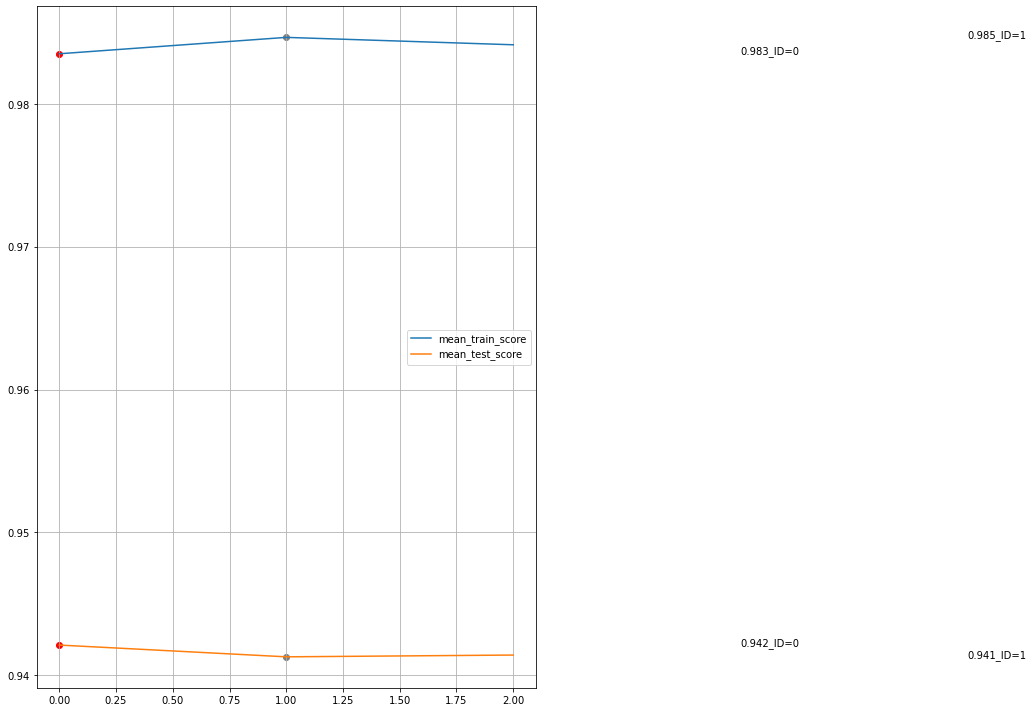

In [61]:
scores = pd.DataFrame(grid_search.cv_results_)

from numpy import array
from numpy.ma import masked_array
from numpy import *

col_names = ['mean_train_score', 'mean_test_score']
means_df = scores[col_names]
ax = means_df.plot(kind='line', grid=True)


from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

#plt.rcParams["figure.dpi"] = 800

max_ids = means_df.idxmax(axis=0)

for i in range(len(max_ids)):
    for col_name in col_names:
        value = means_df[col_name][max_ids[i]]
        id = max_ids[i]
        
        color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'
        
        ax.scatter([id], [value],
                   marker='o',
                   color=color,
                   label='point',)

        ax.annotate(str(round(value, 3))+"_ID="+str(id),
                    (id, value),
                    xytext=(id+3, value))
        

In [59]:

scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.815937,0.069929,0.142773,0.002385,0.21,{'eta': 0.21},0.938873,0.944676,0.942304,0.942386,...,0.942116,0.001856,1,0.982059,0.983389,0.983336,0.984685,0.984026,0.983499,0.000871
1,4.842063,0.177692,0.142833,0.002073,0.22,{'eta': 0.22},0.940349,0.943392,0.942595,0.942025,...,0.941711,0.001253,2,0.985452,0.983478,0.984373,0.983831,0.983760,0.984179,0.000700
2,4.836301,0.083167,0.141421,0.000748,0.23,{'eta': 0.23},0.939322,0.944720,0.940000,0.940443,...,0.940675,0.002092,3,0.984934,0.984863,0.984684,0.985769,0.985183,0.985087,0.000377


In [63]:
_ = model.fit(X_train, y_train)

In [64]:
predicted = model.predict(X_test)

In [65]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.9464351680827484


In [66]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
sorted_score

[('tls_joint_isoitu_policy_crt_count', 193.35751342773438),
 ('tls_expired_chain', 125.24917602539062),
 ('lex_www_flag', 104.7162094116211),
 ('lex_digit_count', 84.33548736572266),
 ('lex_phishing_keyword_count', 81.1497802734375),
 ('tls_client_auth_crt_count', 62.194942474365234),
 ('rdap_domain_registration_period', 60.41508483886719),
 ('dns_domain_name_in_mx', 55.35472106933594),
 ('dns_txt_mean_entropy', 51.096675872802734),
 ('dns_NS_count', 46.9649658203125),
 ('tls_common_name_count', 46.5867805480957),
 ('tls_leaf_cert_validity_len', 43.316444396972656),
 ('tls_root_cert_validity_remaining', 41.349388122558594),
 ('tls_isoitu_policy_oid', 38.6856803894043),
 ('dns_TXT_count', 38.30717849731445),
 ('dns_CNAME_count', 36.11223220825195),
 ('tls_broken_chain', 34.65865707397461),
 ('lex_sub_count', 29.868894577026367),
 ('tls_root_cert_validity_len', 29.799898147583008),
 ('lex_tld_len', 29.583694458007812),
 ('dns_soa_retry', 28.250524520874023),
 ('tls_subject_count', 28.017

In [67]:
_ = model.fit(X_train, y_train)

In [68]:
predicted = model.predict(X_test)

In [69]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.9464351680827484


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predicted, labels=[1,0]))
print(" ")
print(classification_report(y_test, predicted, digits=4))


[[10248   850]
 [  310 77198]]
 
              precision    recall  f1-score   support

           0     0.9891    0.9960    0.9925     77508
           1     0.9706    0.9234    0.9464     11098

    accuracy                         0.9869     88606
   macro avg     0.9799    0.9597    0.9695     88606
weighted avg     0.9868    0.9869    0.9868     88606



In [19]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
    
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    #false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test['label'].values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [96]:
import hashlib
s = "ahoj"
int(hashlib.md5(s.encode("ascii")).hexdigest(), 16) % 2147483647


375790338